In [2]:
!pip install tweepy

import numpy as np
import tweepy
import pickle
import pandas as pd
import csv
import time

In [122]:
rcp = pd.read_csv('rcp polling averages.csv')
rcp['Date'] = pd.to_datetime(rcp['Date'])
rcp['Date'] = rcp['Date'].apply(lambda d: d.date())
rcp = rcp.set_index('Date')
rcp.head()

,Biden,Trump
Date,,
2020-11-03,51.2,44.0
2020-11-02,51.1,44.2
2020-11-01,51.1,43.9
2020-10-31,51.3,43.5
2020-10-30,51.4,43.5


In [141]:
canidate_tweets = pickle.load(open( "My Data/canidate_tweets.p", "rb"))
canidates = pickle.load(open( "My Data/canidates.p", "rb"))

In [142]:
#IMPORTANT METRICS FOR USERS: Followers, Favorites, Tweets (including retweets)
accounts = []
for c in canidates:
    account = [c.id, c.name, c.followers_count, c.favourites_count, c.statuses_count]
    accounts.append(account)

In [143]:
accounts = pd.DataFrame(accounts, columns=['User ID', 'Name', 'Followers', 'Favorites', 'Tweets'])
accounts = accounts.set_index('User ID')

In [144]:
accounts.head()

,Name,Followers,Favorites,Tweets
User ID,,,,
939091,Joe Biden,19998880,20,6861
30354991,Kamala Harris,12430091,366,15284
803694179079458816,Kamala Harris,4214320,1088,5520
25073877,Donald J. Trump,88856307,6,58724
22203756,Mike Pence,5916316,742,12836


In [145]:
#IMPORTANT METRICS FOR TWEETS: ID, User ID, Time, Text, Retweets, Favorites
tweets = []
for c in canidate_tweets:
    for t in c:
        tweet = [t.id, t.user.id, t.user.name, t.user.followers_count, t.created_at, t.text, t.retweet_count, t.favorite_count]
        tweets.append(tweet)

In [146]:
tweets = pd.DataFrame(tweets, columns=['Tweet ID', 'User ID', 'User Name', 'Followers', 'Time', 'Text', 'Retweets', 'Favorites'])
tweets = tweets.set_index('Tweet ID')
tweets['Party'] = 1
tweets.loc[tweets['User Name'] == 'Joe Biden', 'Party'] = 0
tweets.loc[tweets['User Name'] == 'Kamala Harris', 'Party'] = 0
tweets = tweets[tweets['Favorites']!=0]

In [147]:
#Getting rid of all tweets after the election and before July
tweets1 = tweets[tweets['Time'] > pd.to_datetime('20200701', format='%Y%m%d')]
tweets1 = tweets1[tweets1['Time'] < pd.to_datetime('20201104', format='%Y%m%d')]

In [148]:
tweets1.head()

,User ID,User Name,Followers,Time,Text,Retweets,Favorites,Party
Tweet ID,,,,,,,,
1323770935728607237,939091,Joe Biden,19998870,2020-11-03 23:36:00,As polls begin to close in certain parts of th...,17870,118004,0
1323761880234553346,939091,Joe Biden,19998870,2020-11-03 23:00:01,"Folks, time is running out to make your voice ...",4076,39275,0
1323753975221522433,939091,Joe Biden,19998870,2020-11-03 22:28:36,This is our moment to prove that:\n\nLove is m...,25961,192593,0
1323747783732535300,939091,Joe Biden,19998870,2020-11-03 22:04:00,"Let's win this thing, Pennsylvania! https://t....",15846,205181,0
1323739479069392904,939091,Joe Biden,19998870,2020-11-03 21:31:00,Who we are. What we stand for. Who we are goin...,6768,57250,0


Modeling Just Off Just Bidens Tweets

In [189]:
biden = tweets1[tweets1['User Name']=='Joe Biden']

In [190]:
biden_clean = biden.set_index('Time')
biden_clean = biden_clean[['Retweets', 'Favorites', 'Followers']]
biden_clean['Re/Fo'] = biden_clean['Retweets'] / biden_clean['Followers']
biden_clean['Fa/Fo'] = biden_clean['Favorites'] / biden_clean['Followers']

In [199]:
#Here we resample the data to aggregate it by the day
biden_daily = biden_clean[biden_clean.columns.to_list()].resample('D').mean()

In [201]:
polling = []
for date in biden_daily.index:
    polling.append(rcp.filter([date.date()],axis=0)['Biden'][0])

In [202]:
biden_daily['RCP'] = polling

In [222]:
X_train = biden_daily.loc[:'2020-09'].drop(['RCP'], axis = 1)
y_train = biden_daily.loc[:'2020-09', 'RCP']

X_test = biden_daily.loc['2020-10':].drop(['RCP'], axis = 1)
y_test = biden_daily.loc['2020-10':, 'RCP']

In [223]:
#Borrowed from https://towardsdatascience.com/time-series-modeling-using-scikit-pandas-and-numpy-682e3b8db8d1
#Method to output important metrics of different regression techniques
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [224]:
# machine learning
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

models = []
models.append(('LR', LinearRegression()))
models.append(('SVR', SVR()))
models.append(('KNN', KNeighborsRegressor())) 
models.append(('DT', DecisionTreeRegressor())) 
models.append(('RF', RandomForestRegressor())) # Ensemble method - collection of many decision trees
models.append(('NN', MLPRegressor(solver = 'lbfgs')))  #neural network

names = []
outputs = []
# Evaluate each model in turn
for name, model in models:
    names.append(name)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    outputs.append(y_pred)
    print('%s:' % (name))
    regression_results(y_test, y_pred)

LR:
explained_variance:  -0.2429
mean_squared_log_error:  0.0008
r2:  -8.8828
MAE:  1.3732
MSE:  2.1569
RMSE:  1.4686
SVR:
explained_variance:  0.0
mean_squared_log_error:  0.001
r2:  -10.8421
MAE:  1.5383
MSE:  2.5845
RMSE:  1.6076
KNN:
explained_variance:  -0.1517
mean_squared_log_error:  0.0009
r2:  -9.6763
MAE:  1.4418
MSE:  2.33
RMSE:  1.5264
DT:
explained_variance:  -0.4369
mean_squared_log_error:  0.0007
r2:  -7.4956
MAE:  1.2412
MSE:  1.8541
RMSE:  1.3617
RF:
explained_variance:  -0.2024
mean_squared_log_error:  0.0008
r2:  -8.5037
MAE:  1.346
MSE:  2.0741
RMSE:  1.4402
NN:
explained_variance:  -0.3276
mean_squared_log_error:  0.0009
r2:  -9.4364
MAE:  1.4099
MSE:  2.2777
RMSE:  1.5092


In [225]:
from matplotlib import pyplot as plt

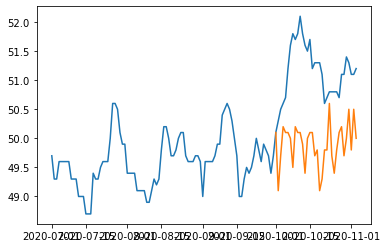

In [231]:
plt.plot(biden_daily['RCP'])
plt.plot(X_test.index, outputs[3]);